In [1]:
import sasktran as sk
import numpy as np
import datetime as dt
import time as T
import cv2
from joblib import Parallel, delayed
import numba as nb
import os
import paramiko
from scp import SCPClient
import subprocess
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.transforms as mtransforms
import matplotlib.colors as mcolors    
import math
import os
from osgeo import gdal
import xarray as xr
from skimage.measure import block_reduce
from ftplib import FTP
import rioxarray
import ephem
import numpy.ma as ma
import rioxarray


# Function

In [2]:
# from Himawari8_AHI_BRDF.BRDF_test.ipynb:pylance-notebook-cell:W5sdnNjb2RlLXJlbW90ZQ== import SZA_PATH

SR_PATH = '/data01/people/liwei/AC_Result/'
VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_10.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_10.dat'
LAND_MASK_PATH = '/data01/GEO/INPUT/LAND_MASK/Landmask_10.dat'
SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'

# AHI VZA/VAA Load
with open(VZA_PATH,'rb') as fp:
    VZA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(VAA_PATH,'rb') as fp:
    VAA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(LAND_MASK_PATH,'rb') as fp:
    Ocean_mask = np.frombuffer(fp.read(),dtype='u1').reshape(12000,12000)
res = 0.01
lat = np.linspace(60 - res/2 ,-60 + res/2,3000)
lon = np.linspace(85 + res/2 ,205 - res/2,3000)

def read_angle_data(d):
    
    AHI_date = d[4:11]

    sza_file_name = 'AHI_SZA_2018{}5.dat'.format(AHI_date)
    saa_file_name = 'AHI_SAA_2018{}5.dat'.format(AHI_date)

    fp = open(SZA_PATH + sza_file_name,'rb')
    AHI_SZA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
    fp.close()
    AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)

    fp = open(SAA_PATH + saa_file_name,'rb')
    AHI_SAA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000) / 100
    fp.close()
    AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)        
    return AHI_SZA,AHI_SAA
    
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD + HH + MIN
    return YYYY,MM,DD,HH,MIN,date


def Get_Kernel_Input_Parameter(date,band):
    if band == 4:
        if os.path.exists(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date),'rb')
            SR = np.frombuffer(fp.read(),dtype='f4').reshape(12000,12000)
            fp.close()
        else:
            SR = np.full((12000,12000),np.nan)
    if band == 3:
        if os.path.exists(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date)):
            fp = open(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date),'rb')
            SR = np.frombuffer(fp.read(),dtype='f4').reshape(12000,12000)
            fp.close()
        else:
            SR = np.full((12000,12000),np.nan)
            
    return SR



def Mask_Merge(date):
    # Read cloud mask
    # cloud 0, clear 1
    if os.path.exists('/data01/people/liwei/AHIcm_algo_v0/cloudmask/{}/AHIcm.v0.{}.dat'.format(date[:6],date)):
        fp = open('/data01/people/liwei/AHIcm_algo_v0/cloudmask/{}/AHIcm.v0.{}.dat'.format(date[:6],date),'rb')
        cloudmask = np.frombuffer(fp.read(),dtype='<f4').reshape(6000,6000)
        fp.close()
        cloudmask = cv2.resize(np.array(cloudmask,dtype='float32'),(12000,12000),interpolation=cv2.INTER_NEAREST)

        MASK = (Ocean_mask + cloudmask)
        MASK = np.where(MASK==2,1,0)
        MASK = MASK.astype(bool)
        return MASK
    else :

        return np.full((12000,12000),0).astype(bool)

import numpy.ma as ma

from sklearn.metrics import r2_score,mean_squared_error
color_list = list(mcolors.CSS4_COLORS)
def add_right_cax(ax, pad, width):

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax
def identifer(li):
    result = []
    for a in li:
        mean = np.nanmean(a)
        std = np.nanstd(a) 
        down = mean - 3 * std
        up =  mean + 3 * std
        n_a = np.where(a < down,np.nan,a)
        n_a = np.where(n_a > up,np.nan,n_a)
        result.append(n_a)
    return result
    
def RTK (sza,vza,raa):
    cos_xi = np.cos(np.radians(sza)) * np.cos(np.radians(vza)) + np.sin(np.radians(sza)) * np.sin(np.radians(vza))* np.cos(np.radians(raa))
    xi = np.arccos(cos_xi)
    rtk = (((np.pi/2 - xi) * cos_xi + np.sin(xi)) / (np.cos(np.radians(sza)) + np.cos(np.radians(vza)))) - np.pi/4
    return rtk
def RJN(sza,vza,raa):
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))
    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    rjn = 1/2*np.pi * ((np.pi - np.radians(raa)) * cos_raa + sin_raa) * tan_sza * tan_vza - 1/np.pi * (tan_sza + tan_vza + D)
    return rjn

def LSR_MaxMin(sza,vza,raa):
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))

    sec_sza = 1 / cos_sza
    sec_vza = 1 / cos_vza

    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    sec__sza = 1 / cos__sza
    sec__vza = 1 / cos__vza

    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    cos_t = (2 * (np.sqrt(np.square(D) + np.square(tan_sza * tan_vza * sin_raa)))) / (sec__sza + sec__vza)
    
    cos_t = np.where(cos_t>1,1,cos_t)
    cos_t = np.where(cos_t<-1,-1,cos_t)
    
    
    t = np.arccos(cos_t)
    O = (1/np.pi) * (t - np.sin(t) * cos_t) *  (sec__sza + sec__vza)
    lsr = O - sec__sza - sec__vza + 0.5 * (1 + cos__xi) * sec__sza * sec__vza
    return lsr

def LSR(sza,vza,raa):
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))

    sec_sza = 1 / cos_sza
    sec_vza = 1 / cos_vza

    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    sec__sza = 1 / cos__sza
    sec__vza = 1 / cos__vza

    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    cos_t = (2 * (np.sqrt(np.square(D) + np.square(tan_sza * tan_vza * sin_raa)))) / (sec__sza + sec__vza)
    
    t = np.arccos(cos_t)
    O = (1/np.pi) * (t - np.sin(t) * cos_t) *  (sec__sza + sec__vza)
    lsr = O - sec__sza - sec__vza + 0.5 * (1 + cos__xi) * sec__sza * sec__vza
    return lsr

def LSD(sza,vza,raa):
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))

    sec_sza = 1 / cos_sza
    sec_vza = 1 / cos_vza

    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    sec__sza = 1 / cos__sza
    sec__vza = 1 / cos__vza

    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    cos_t = (2 * (np.sqrt(np.square(D) + np.square(tan_sza * tan_vza * sin_raa)))) / (sec__sza + sec__vza)
    t = np.arccos(cos_t)
    O = (1/np.pi) * (t - np.sin(t) * cos_t) *  (sec__sza + sec__vza)
    lsd = ((1 + cos__xi) * sec__vza) / (sec__sza + sec__vza - O) -2
    return lsd

def get_new_kgeo(i,j):
    
    a = np.array(kgeo_day_LSR)[:,i,j]
    s_idx ,e_idx = a.size // 2,a.size // 2
    
    while s_idx != -1:
        if not np.isnan(a[s_idx]):
            s_idx -= 1
        else:
            break
    while e_idx != a.size:
        if not np.isnan(a[e_idx]):
            e_idx += 1
        else:
            break  
            
    max_idx = np.nanargmax(a)
   
    
    if s_idx == -1 and e_idx != a.size:
        x = np.arange(max_idx + 2 ,e_idx ,1)
        y = a[max_idx + 2:e_idx]
        x2 = np.arange(e_idx,a.size,1)
        p2 = np.polyfit(x, y, 2)
        yvals2 = np.polyval(p2,x2).tolist()
        
        return a[0:e_idx].tolist() + yvals2
        
    elif s_idx != -1 and e_idx == a.size:
        x = np.arange(s_idx+1 ,max_idx -2 ,1)
        y =a[s_idx+1:max_idx -2]
        x1 = np.arange(0,s_idx+1,1)
        p1 = np.polyfit(x, y, 2)
        yvals1 = np.polyval(p1,x1).tolist()
        return yvals1 + a[s_idx+1:].tolist()
        
    elif s_idx != -1 and e_idx != a.size:
        x = np.arange(s_idx+1 ,max_idx -2 ,1)
        y =a[s_idx+1:max_idx -2]
        x1 = np.arange(0,s_idx+1,1)
        p1 = np.polyfit(x, y, 2)
        yvals1 = np.polyval(p1,x1).tolist()

        x = np.arange(max_idx + 2 ,e_idx ,1)
        y = a[max_idx + 2:e_idx]
        x2 = np.arange(e_idx,a.size,1)
        p2 = np.polyfit(x, y, 2)
        yvals2 = np.polyval(p2,x2).tolist()
        return yvals1 + a[s_idx+1:e_idx].tolist() + yvals2



def calc_sunpos(dtime,lat,lon):
    sun = ephem.Sun()
    obs = ephem.Observer()
    obs.date = dtime
    obs.lat = lat*math.pi/180.0
    obs.long = lon*math.pi/180.0
    sun.compute(obs)
    return np.degrees(sun.az),90.0-np.degrees(sun.alt)


class SGLI_L2_Downloader:
    
    def __init__ (self, User_ID , ProductName, Ver, Date , Tile , Obrit ,ParaVer, Target_path):
        self.User_ID = User_ID
        self.ProductName = ProductName
        self.Ver = Ver
        self.Date = Date
        self.Tile = Tile
        self.Obrit = Obrit
        self.ParaVer = ParaVer
        self.Target_path = Target_path
        
        
    def path (self):
        return '/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.{}/{}/{}/{}/{}'.format(self.ProductName, self.Ver, self.Date[0:4], self.Date[4:6], self.Date[6:8])

    def filename (self):
        return 'GC1SG1_{}{}01D_T{}_L2SG_{}Q_{}00{}.h5'.format(self.Date, self.Obrit, self.Tile, self.ProductName, self.Ver, self.ParaVer)
    
    def login (self):
        ftp_addr = 'ftp.gportal.jaxa.jp'
        f = FTP(ftp_addr)
        f.login(self.User_ID,'anonymous')
        
        return f
    
    def download (self, f):
        remote_filepath = self.path()
        f.cwd(remote_filepath)
        list=f.nlst()
        
        bufsize=1024
        if self.filename() in list:
            data = open ('{}{}'.format(self.Target_path, self.filename()), 'wb')
            filename = 'RETR ' + self.filename()
            f.retrbinary(filename,data.write,bufsize)
            return 'y'
        else:
            return 'n'
    
    def logout (self, f):
        f.quit()
    
def reporjection_GEO(filename,Band,Target_path):
    
    #print(path)
    p = subprocess.Popen('/data01/people/liwei/Data/GCOM-C_RSRF/SGLI_geo_map_linux.exe {} -d Geometry_data/{} -o {} -r 0 -s 30'.format(filename,Band,Target_path[:-1]),shell=True)
    p.communicate()
    # subprocess.check_output('/data01/people/liwei/Data/GCOM-C_RSRF/SGLI_geo_map_linux.exe {} -d Geometry_data/{} -o {} -s 7.5'.format(filename,Band,Target_path[:-1]), shell=True) 
    
def mkdir(path):
    folder = os.path.exists(path) 
    if not folder:
        os.makedirs(path)
        
    
def SGLI_2_AHI_GEO(filepath,lat,lon):  
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != -32768:
        data = data * 0.01
        return data
    else:
        return np.nan
    
def SGLI_2_AHI_Ref(filepath,lat,lon):  
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != 65535:
        data = data * 0.0001
        return data
    else:
        return np.nan    

    
def SGLI_2_AHI_TIME(filepath,lat,lon):
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != -32768.:
        data = data * 0.001
        return data
    else:
        return np.nan

def download_tile(date,save_tile_path,tile):
    g = SGLI_L2_Downloader(
        'galiwei ' ,
        'RSRF', 
        '3', 
         date , 
         tile, 
        'D' , 
        '1' ,
         save_tile_path
        )
    f = g.login()
    
    if os.path.exists(save_tile_path + g.filename()):
        return g.filename()
    
    else :
        rc = g.download(f)
        if rc == 'n':
            g.logout(f)
            return 'n'
        else:
            g.logout(f)
            return g.filename()
    

def Decompression(t,fn):
    if os.path.exists('{}.bz2'.format(t + fn)):
        p = subprocess.Popen('lbzip2 -d {}.bz2'.format(t + fn),shell=True)
        p.communicate()
        
def ahi_lon_timeoffset(lon): 
    lon_interval = 15 
    UTC_e_lon = lon_interval / 2 
    timeoffset = math.ceil((lon - UTC_e_lon) / lon_interval) 
    return timeoffset 
        
def Time_split_SGLI(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD
    return YYYY,MM,DD,HH,MIN,date
    
    
def lonlat2tileidx(latlon:tuple)->tuple:
    # vertical pixel count in one tile, horizontal pixel count in one tile
    lintile, coltile = 1200, 1200
    # vertical tile count, horizontal tile count
    vtilenum, htilenum = 18, 36
    # [deg/pixel]
    d = 180.0/lintile/vtilenum
    # from S-pole to N-pole
    NL = 180.0/d
    NP0 = 2*np.round(180.0/d)
    res1 = (90 - latlon[0])/d-0.5
    V_idx = res1 // lintile
    # Y_idx = res1 - V_idx * lintile
    # GCOM-C use integer NPi
    NPi = round(NP0*np.cos(np.deg2rad(latlon[0])))
    res2 = latlon[1]*NPi/360 - 0.5 + NP0/2
    H_idx = res2 // coltile
    # X_idx = res2 - H_idx * coltile
    return str(round(V_idx)).rjust(2,'0')  + str(round(H_idx)).rjust(2,'0') 
def SGLI_SA(h,_min,lat,lon):

    d = dt.datetime(int(YYYY),int(MM),int(DD),h,_min)
    
    SAA,SZA = calc_sunpos(d,lat,lon)
    return SAA,SZA
reporjection_file_path = '/data01/people/liwei/Data/GCOM-C_RSRF/reporjection/'
tile_file_path = '/data01/people/liwei/Data/GCOM-C_RSRF/tile/'

def SGLI_2_AHI_IMAGE(filepath,lat,lon):
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    data = np.where(data != 65535, data ,np.nan)
    data = data * 0.0001
    return data

# Check Landcover / Altitude

In [599]:
44.7+85

129.7

In [611]:
j_idx

4000

In [68]:
# open Shrubland 7
i_idx,j_idx = 8698,4470 # 1~6
# i_idx,j_idx = 8400,4000 # 1~6
# i_idx,j_idx = 9000,4000
# i_idx,j_idx = 8500,3500
# i_idx,j_idx = 8750,4500    
#Grassland 10
# i_idx,j_idx = 7548,5825
# i_idx,j_idx = 9435,3425
# i_idx,j_idx = 1628,3059 # 内蒙古草原

#Cropland 12
# i_idx,j_idx = 9142,3220
# i_idx,j_idx = 1645,3931 # 东北农田
# i_idx,j_idx = 2290,3162 # 华北农田

# Barren
# i_idx,j_idx = 8900,5740
# i_idx,j_idx = 1830,1960 # 甘肃裸地

In [69]:

r = 50
with open( '/data01/people/liwei/Data/Landcover/MCD12Q1.006.LC.CEReS_H8AHI.01km.MEAN.NA.ann.bsq.byt','rb') as fp:      

    Landcover = np.frombuffer(fp.read(),dtype='uint8').reshape(12000, 12000)
print(Landcover[i_idx-r:i_idx+r,j_idx-r:j_idx+r])

AL_PATH = '/data01/GEO/INPUT/ELEVATION_GEO/AHI/MERIT_DEM_AHI_10km.dat'
with open(AL_PATH ,'rb') as fp:
    AHI_AL = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000)
print(AHI_AL[i_idx-r:i_idx+r,j_idx-r:j_idx+r])


[[7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 ...
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]
 [7 7 7 ... 7 7 7]]
[[535 537 537 ... 651 656 654]
 [533 537 539 ... 648 660 656]
 [533 535 537 ... 648 659 661]
 ...
 [418 413 409 ... 504 487 487]
 [411 406 406 ... 508 486 487]
 [404 403 405 ... 484 480 481]]


In [657]:
AHI_AL[i_idx-r:i_idx+r,j_idx-r:j_idx+r].min()

371

In [659]:
2*r

12

# MAIN FUNCTION

In [70]:

kvol = np.array([])
# kgeo_RJN = []
kgeo_LSR = np.array([])
kgeo_MaxMin = np.array([])
# kgeo_LSD = []
kgeo_fitting = np.array([])
Ref = np.array([])
# time_list = []
MASK = np.array([])
Ref = np.array([])
r = 50
band = 4
d_count = 1
for d in range(21,26):
    date_start = '2018-01-{} 00:00'.format(str(d))
    date_end = '2018-01-{} 09:00'.format(str(d))
    date_t = dt.timedelta(minutes=10)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    kvol_day = np.array([])
    kgeo_day_RJN = np.array([])
    kgeo_day_LSR = np.array([])
    kgeo_day_MaxMin = np.array([])
    Ref_day = np.array([])
    cm_day = np.array([])
    # time_list = []
    print(d)
    count = 1
    
    while date_time_now < date_e:
        # print(date_time_now)
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )

        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
        
        
        if os.path.exists('/data01/people/liwei/AHIcm_algo_v0/cloudmask/{}/AHIcm.v0.{}.dat'.format(date[:6],date)):
            # print(u'1当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
            fp = open('/data01/people/liwei/AHIcm_algo_v0/cloudmask/{}/AHIcm.v0.{}.dat'.format(date[:6],date),'rb')
            cloudmask = np.frombuffer(fp.read(),dtype='<f4').reshape(6000,6000)
            fp.close()
            cloudmask = cv2.resize(np.array(cloudmask,dtype='float32'),(12000,12000),interpolation=cv2.INTER_NEAREST)
            # print(u'2当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
            c_o_mask = Ocean_mask + cloudmask
            c_o_mask_1 = np.where(c_o_mask==2,1,0).astype(bool)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
            del cloudmask,c_o_mask
            # print(u'3当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
        else :

            c_o_mask_1 = np.full((2*r,2*r),0).astype(bool)
            
        
        cm_day = np.append(cm_day,c_o_mask_1).reshape(count,2*r,2*r)
        
        SZA,SAA = read_angle_data(date)
        RAA = abs(SAA - VAA)
        RAA[RAA>180]=360-RAA[RAA>180]
        RAA_1 = RAA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        SZA_1 = SZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        SAA_1 = SAA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        del SZA,SAA,RAA
        
        
        if band == 1:
            if os.path.exists(SR_PATH + '{}_AC/{}_b01.dat'.format(date,date)):
                fp = open(SR_PATH + '{}_AC/{}_b01.dat'.format(date,date),'rb')
                SR = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r] / 10000
                fp.close()
            else:
                SR = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        elif band == 2:
            if os.path.exists(SR_PATH + '{}_AC/{}_b02.dat'.format(date,date)):
                fp = open(SR_PATH + '{}_AC/{}_b02.dat'.format(date,date),'rb')
                SR = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r] / 10000
                fp.close()
            else:
                SR = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
    
        elif band == 3:
            if os.path.exists(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date)):
                fp = open(SR_PATH + '{}_AC/{}_b03.dat'.format(date,date),'rb')
                SR = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r] / 10000
                fp.close()
            else:
                SR = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        
        elif band == 4:
            if os.path.exists(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date)):
                fp = open(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date),'rb')
                SR = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r] / 10000
                fp.close()
            else:
                SR = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
                
        elif band == 5:
            if os.path.exists(SR_PATH + '{}_AC/{}_b05.dat'.format(date,date)):
                fp = open(SR_PATH + '{}_AC/{}_b05.dat'.format(date,date),'rb')
                SR = np.frombuffer(fp.read(),dtype='int16').reshape(6000,6000) / 10000
                SR = cv2.resize(np.array(SR,dtype='float32'),(12000,12000),interpolation=cv2.INTER_NEAREST)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
                fp.close()
            else:
                SR = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]         
                
        elif band == 6:
            if os.path.exists(SR_PATH + '{}_AC/{}_b06.dat'.format(date,date)):
                fp = open(SR_PATH + '{}_AC/{}_b06.dat'.format(date,date),'rb')
                SR = np.frombuffer(fp.read(),dtype='int16').reshape(6000,6000) / 10000
                SR = cv2.resize(np.array(SR,dtype='float32'),(12000,12000),interpolation=cv2.INTER_NEAREST)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
                fp.close()
            else:
                SR = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]


        # if band == 4:
        #     if os.path.exists(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date)):
        #         fp = open(SR_PATH + '{}_AC/{}_b04.dat'.format(date,date),'rb')
        #         SR = np.frombuffer(fp.read(),dtype='f4').reshape(12000,12000)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
        #         fp.close()
        #     else:
        #         SR = np.full((12000,12000),np.nan)[i_idx-r:i_idx+r,j_idx-r:j_idx+r]        


        
        kgeo_day_LSR = np.append(kgeo_day_LSR,LSR(SZA_1,VZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r],RAA_1)).reshape(count,2*r,2*r)
        kgeo_day_MaxMin = np.append(kgeo_day_MaxMin,LSR_MaxMin(SZA_1,VZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r],RAA_1)).reshape(count,2*r,2*r)
        kvol_day = np.append(kvol_day,RTK(SZA_1,VZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r],RAA_1)).reshape(count,2*r,2*r)
        Ref_day = np.append(Ref_day,SR).reshape(count,2*r,2*r)
        

        
        end_time = T.time()
        TIME = end_time - start_time
        # print('time: {:.1f} secs, {:.1f} mins,{:.1f} hours'.format(TIME,TIME/60,TIME/3600))
        count += 1
        date_time_now = date_time_now + date_t
        # print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024 / 1024) )
        
        
    MASK = np.append(MASK,cm_day).reshape(d_count,54,2*r,2*r)
    Ref = np.append(Ref,Ref_day).reshape(d_count,54,2*r,2*r)

    Kresult = Parallel(n_jobs=20)(delayed(get_new_kgeo)(i,j) for i in range(2*r) for j in range(2*r)) # Fitting
    kgeo_fitting = np.append(kgeo_fitting,np.array(Kresult).T.reshape(54,2*r,2*r)).reshape(d_count,54,2*r,2*r)
    kgeo_MaxMin = np.append(kgeo_MaxMin,kgeo_day_MaxMin).reshape(d_count,54,2*r,2*r)
    kgeo_LSR = np.append(kgeo_LSR,kgeo_day_LSR).reshape(d_count,54,2*r,2*r)
    kvol = np.append(kvol,kvol_day).reshape(d_count,54,2*r,2*r)
    d_count += 1
    
    
    
kgeo_fitting_cm = ma.array(np.array(kgeo_fitting),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(5*54,2*r,2*r)
kgeo_MaxMin_cm = ma.array(np.array(kgeo_MaxMin),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(5*54,2*r,2*r)
# kgeo_RJN_cm = ma.array(np.array(kgeo_RJN),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(5*54,10,10)
kgeo_LSR_cm = ma.array(np.array(kgeo_LSR),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(5*54,2*r,2*r)

kvol_cm = ma.array(np.array(kvol),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(5*54,2*r,2*r)
Ref_cm = ma.array(np.array(Ref),mask = ~np.array(MASK).astype(bool),fill_value = np.nan).filled().reshape(5*54,2*r,2*r)

21


<ipython-input-2-a1e714db3bfe>:209: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


22
23
24
25


In [54]:
Ref_cm.shape

(270, 100, 100)

In [5]:
# Get Label
date_start = '2018-01-01 08:00'
date_end = '2018-01-01 17:00'
date_t = dt.timedelta(minutes=10)
# date_t = dt.timedelta(minutes=30)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
label = []
while date_time_now < date_e:
    # print(date_time_now)
    start_time = T.time()
    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
    label.append(HH+MIN)
    date_time_now = date_time_now + date_t

(-5.0, 1.0)

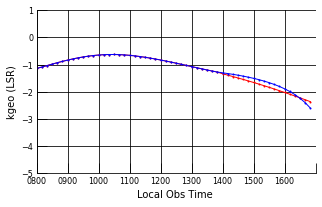

In [606]:

axis_min = -5
axis_max = 1
r = 5
fig = plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# ax1.plot(label,LSR(s,VZA[80,120],np.array(AHI_RAA)[:,80,120]),color = 'r',marker="o",markersize=1,linewidth=1)
ax1.plot(label,np.array(kgeo_fitting)[1,:,5,5],color = 'r',marker="o",markersize=1,linewidth=1)
ax1.plot(label,np.array(kgeo_MaxMin)[1,:,5,5],color = 'b',marker="o",markersize=1,linewidth=1)


# ax1.set_xticks(np.linspace(0,105,106))
# ax1.set_yticks(np.arange(axis_min,1.1,1))
ax1.set_xticks(np.arange(0,56,6))

ax1.set_xlabel("Local Obs Time ",fontsize=10)
ax1.set_ylabel("kgeo (LSR)",fontsize=10)
ax1.grid(alpha=1,color='k')

ax1.set_xlim(0,54)
ax1.set_ylim(axis_min,axis_max)


(-0.1, 0.35)

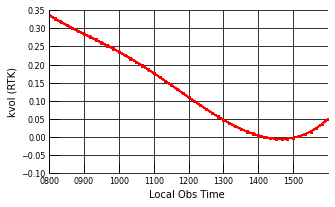

In [255]:


axis_min = -0.1
axis_max = 0.35
r = 5
fig = plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# ax1.plot(label,np.array(kvol)[:,i_idx,j_idx],color = 'r',marker="o",markersize=1,linewidth=1,label='Ref')


for i in range(2*r):
    for j in range(2*r):
        ax1.plot(label,np.array(kvol)[0,:,i,j],color = 'r',marker="o",markersize=1,linewidth=1)



# ax1.set_xticks(np.linspace(0,105,106))
# ax1.set_yticks(np.arange(axis_min,1.1,1))
ax1.set_xticks(np.arange(0,43,6))

ax1.set_xlabel("Local Obs Time ",fontsize=10)
ax1.set_ylabel("kvol (RTK)",fontsize=10)
ax1.grid(alpha=1,color='k')

ax1.set_xlim(0,48)
ax1.set_ylim(axis_min,axis_max)
# plt.legend()

#  LSR Range

In [ ]:
sza_test = np.arange(-60,60,1)
vza_test = np.arange(0,80,1)
raa_test = np.arange(0,180,1)
r, theta = np.meshgrid(sza_test, raa_test)


<ipython-input-1020-6562f3d9127e>:29: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


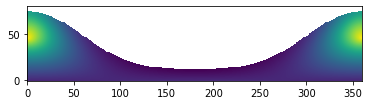

In [ ]:
result = []
for i in range(80):
    c = LSR(sza_test[i],45,raa_test)
    result.append(c)
plt.imshow(np.array(result),origin='lower')

<ipython-input-1093-665ba5a0481f>:96: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


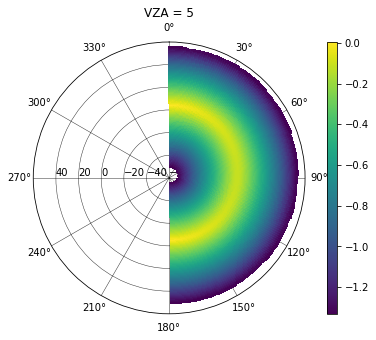

In [ ]:
result = []
for i in range(180):
    c = LSR(sza_test,5,raa_test[i])
    result.append(c)
# r, theta = np.meshgrid(raa_test, sza_test)
fig = plt.figure(figsize=[5,5])
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(-60, 60, 20))
ax.set_rlabel_position(270.0)
ax.set_rlim(-60, 60)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.set_axisbelow('True')
im = ax.pcolormesh(np.radians(theta),r,np.array(result),edgecolors='face')
ax.grid(True, linestyle="-", color="k", linewidth=0.5,alpha=0.8)
ax.tick_params(axis='y',colors='k')
cax = add_right_cax(ax, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
ax.set_title('VZA = 5')
plt.show()

<ipython-input-1093-665ba5a0481f>:96: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


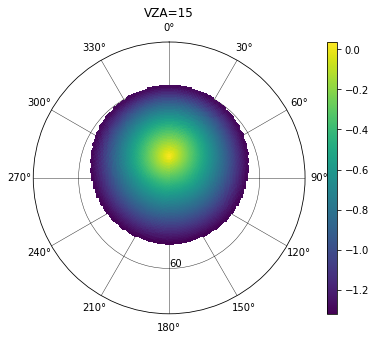

In [ ]:
result = []
for i in range(180):
    c = LSR(sza_test,15,raa_test[i])
    result.append(c)
# r, theta = np.meshgrid(raa_test, sza_test)
fig = plt.figure(figsize=[5,5])
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(0, 90, 30))
ax.set_rlabel_position(180.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.set_axisbelow('True')
im = ax.pcolormesh(np.radians(theta),r,np.array(result),edgecolors='face')
ax.grid(True, linestyle="-", color="k", linewidth=0.5,alpha=0.8)
ax.tick_params(axis='y',colors='k')
cax = add_right_cax(ax, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
# ax.scatter(np.radians(np.array(AHI_SAA)[:,i_idx,j_idx] - VAA[1400:1900,5450:6150][i_idx,j_idx]),np.array(AHI_SZA)[:,i_idx,j_idx], c='r', marker='o', s=40)
ax.set_title('VZA=15')
plt.show()

<ipython-input-1093-665ba5a0481f>:96: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


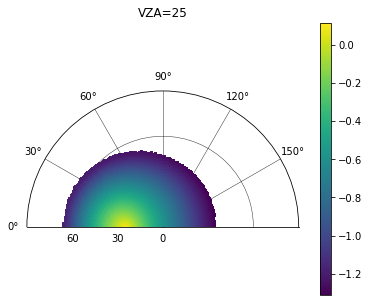

In [ ]:
result = []
for i in range(180):
    c = LSR(sza_test,25,raa_test[i])
    result.append(c)
# r, theta = np.meshgrid(raa_test, sza_test)
fig = plt.figure(figsize=[5,5])
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi)
#设置极坐标系的起始角度为90°
ax.set_theta_direction('clockwise')
ax.set_thetagrids(np.arange(0.0, 180.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(180.0)
ax.set_rgrids(np.arange(0, 90, 30))
ax.set_rlabel_position(180.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.set_axisbelow('True')
im = ax.pcolormesh(np.radians(theta),r,np.array(result),edgecolors='face')
ax.grid(True, linestyle="-", color="k", linewidth=0.5,alpha=0.8)
ax.tick_params(axis='y',colors='k')
cax = add_right_cax(ax, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
ax.set_title('VZA=25')
# plt.imshow(np.array(result),origin='lower')
plt.show()

<ipython-input-1093-665ba5a0481f>:96: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


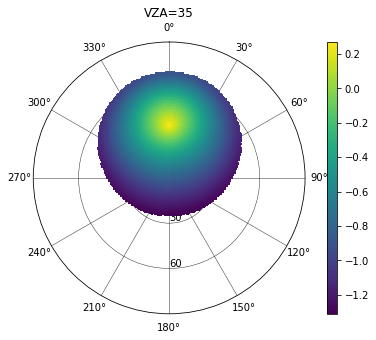

In [ ]:
result = []
for i in range(360):
    c = LSR(sza_test,35,raa_test[i])
    result.append(c)
# r, theta = np.meshgrid(raa_test, sza_test)
fig = plt.figure(figsize=[5,5])
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(0, 90, 30))
ax.set_rlabel_position(180.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.set_axisbelow('True')
im = ax.pcolormesh(np.radians(theta),r,np.array(result),edgecolors='face')
ax.grid(True, linestyle="-", color="k", linewidth=0.5,alpha=0.8)
ax.tick_params(axis='y',colors='k')
cax = add_right_cax(ax, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
ax.set_title('VZA=35')

plt.show()

<ipython-input-1093-665ba5a0481f>:96: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


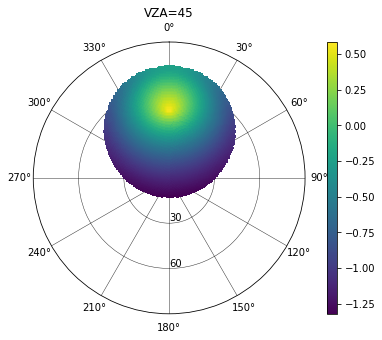

In [ ]:
result = []
for i in range(360):
    c = LSR(sza_test,45,raa_test[i])
    result.append(c)
# r, theta = np.meshgrid(raa_test, sza_test)
fig = plt.figure(figsize=[5,5])
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(0, 90, 30))
ax.set_rlabel_position(180.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.set_axisbelow('True')
im = ax.pcolormesh(np.radians(theta),r,np.array(result),edgecolors='face')
ax.grid(True, linestyle="-", color="k", linewidth=0.5,alpha=0.8)
ax.tick_params(axis='y',colors='k')
cax = add_right_cax(ax, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
# ax.scatter(np.radians(np.array(AHI_SAA)[:,i_idx,j_idx] - VAA[2550:2750,4700:5000][i_idx,j_idx]),np.array(AHI_SZA)[:,i_idx,j_idx], c='r', marker='o', s=40)
ax.set_title('VZA=45')
plt.show()

<ipython-input-1093-665ba5a0481f>:96: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


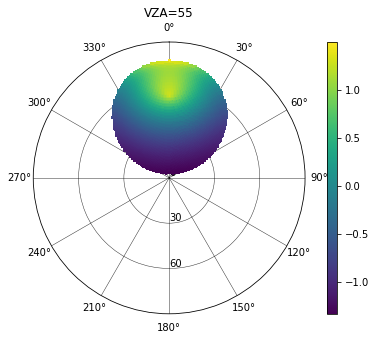

In [ ]:
result = []
for i in range(360):
    c = LSR(sza_test,55,raa_test[i])
    result.append(c)
# r, theta = np.meshgrid(raa_test, sza_test)
fig = plt.figure(figsize=[5,5])
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(0, 90, 30))
ax.set_rlabel_position(180.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.set_axisbelow('True')
im = ax.pcolormesh(np.radians(theta),r,np.array(result),edgecolors='face')
ax.grid(True, linestyle="-", color="k", linewidth=0.5,alpha=0.8)
ax.tick_params(axis='y',colors='k')
cax = add_right_cax(ax, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
ax.set_title('VZA=55')

plt.show()

<ipython-input-991-1a77d0840d1e>:40: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


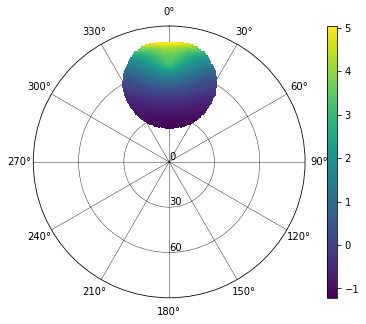

In [ ]:
result = []
for i in range(360):
    c = LSR(sza_test,65,raa_test[i])
    result.append(c)
# r, theta = np.meshgrid(raa_test, sza_test)
fig = plt.figure(figsize=[5,5])
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(0, 90, 30))
ax.set_rlabel_position(180.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.set_axisbelow('True')
im = ax.pcolormesh(np.radians(theta),r,np.array(result),edgecolors='face')
ax.grid(True, linestyle="-", color="k", linewidth=0.5,alpha=0.8)
ax.tick_params(axis='y',colors='k')
cax = add_right_cax(ax, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
plt.show()

In [ ]:
sza_test = np.arange(0,81,1)
vza_test = np.arange(0,81,1)


In [ ]:
np.array(result).shape

(80, 81)

<ipython-input-1093-665ba5a0481f>:96: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


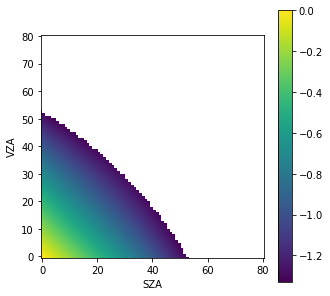

In [ ]:
result = []
for i in range(81):
    c = LSR(sza_test,vza_test[i],180)
    result.append(c)
xis_min = -0.1
axis_max = 0.35

plt.figure(figsize=(5,5))
plt.imshow(np.array(result),origin='lower')
plt.ylabel('VZA')
plt.xlabel('SZA')
plt.colorbar()

# Multiple linear regression

In [6]:
def fitting(dg,dv,i,j):
    r = Ref_cm[:,i,j].reshape(-1,1)
    cm = ~np.isnan(r)
    r = r[cm].reshape(-1,1)
    kv = dv[:,i,j].reshape(-1,1)[cm].reshape(-1,1)
    kg = dg[:,i,j].reshape(-1,1)[cm].reshape(-1,1)

    # 检查是否存在空值，并去除
    if not (np.isnan(kg) | np.isnan(kv)).any():
        k = np.hstack((kv, kg))
    else:
        return np.nan, np.nan, np.nan

    # 检查数据量是否大于40
    if r.size > 40:
        linreg = LinearRegression()
        model = linreg.fit(k, r)
        fi = linreg.intercept_[0]
        fv, fg = linreg.coef_[0]
        return fi, fv, fg
    else:
        return np.nan, np.nan, np.nan

In [55]:
import time
S = time.time()
RESULT = Parallel(n_jobs=15)(delayed(fitting)(kgeo_fitting_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_fitting = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_fitting = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_fitting = np.array(RESULT)[:,2].reshape(2*r,2*r)

# RESULT = Parallel(n_jobs=15)(delayed(fitting)(kgeo_LSR_cm,kvol_cm,i,j) for i in range(10) for j in range(10))
# fiso_LSR = np.array(RESULT)[:,0].reshape(10,10)
# fvol_LSR = np.array(RESULT)[:,1].reshape(10,10)
# fgeo_LSR = np.array(RESULT)[:,2].reshape(10,10)

RESULT = Parallel(n_jobs=15)(delayed(fitting)(kgeo_MaxMin_cm,kvol_cm,i,j) for i in range(2*r) for j in range(2*r))
fiso_MaxMin = np.array(RESULT)[:,0].reshape(2*r,2*r)
fvol_MaxMin = np.array(RESULT)[:,1].reshape(2*r,2*r)
fgeo_MaxMin = np.array(RESULT)[:,2].reshape(2*r,2*r)

# RESULT = Parallel(n_jobs=15)(delayed(fitting)(kgeo_RJN_cm,kvol_cm,i,j) for i in range(10) for j in range(10))
# fiso_RJN = np.array(RESULT)[:,0].reshape(10,10)
# fvol_RJN = np.array(RESULT)[:,1].reshape(10,10)
# fgeo_RJN = np.array(RESULT)[:,2].reshape(10,10)


E = time.time()
print(E-S)

7.916313171386719


In [56]:
fiso_MaxMin.shape

(100, 100)

# Fitting Result

In [668]:
# i_idx,j_idx = 299,212
r = 50
X_MaxMin = np.array(Ref_cm).reshape(5*54,2*r,2*r)[:,:,:]
Y_MaxMin = fiso_MaxMin + np.array(kvol).reshape(5*54,2*r,2*r)[:,:,:]*fvol_MaxMin + np.array(kgeo_MaxMin).reshape(5*54,2*r,2*r)[:,:,:]*fgeo_MaxMin


X_Fitting = np.array(Ref_cm).reshape(5*54,2*r,2*r)[:,:,:]
Y_Fitting = fiso_fitting + np.array(kvol).reshape(5*54,2*r,2*r)[:,:,:]*fvol_fitting + np.array(kgeo_fitting).reshape(5*54,2*r,2*r)[:,:,:]*fgeo_fitting


# X_Fitting_RJN = np.array(Ref_cm).reshape(5*54,10,10)[:,:,:]
# Y_Fitting_RJN = fiso_RJN + np.array(kvol).reshape(5*54,10,10)[:,:,:]*fvol_RJN + np.array(kgeo_RJN).reshape(5*54,10,10)[:,:,:]*fgeo_RJN


# X_Fitting_LSR = np.array(Ref_cm).reshape(7*43,10,10)[:,:,:]
# Y_Fitting_LSR = fiso_LSR + np.array(kvol).reshape(7*43,10,10)[:,:,:]*fvol_LSR + np.array(kgeo_LSR).reshape(7*43,10,10)[:,:,:]*fgeo_LSR

(0.0, 0.6)

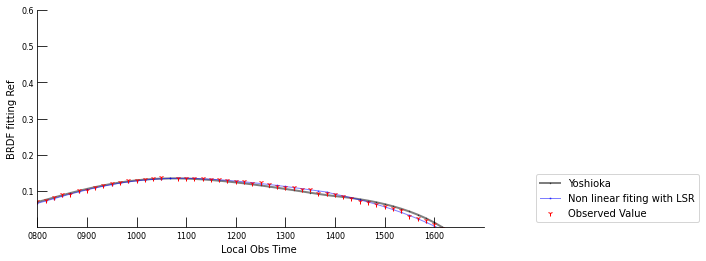

In [609]:
axis_min = 0
axis_max = 0.6

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

# ax1.plot(label,X,color = 'k',marker="o",markersize=1,linewidth=1,label='Ref')
# for i in range(2*r):
#     for j in range(2*r):
#         ax1.plot(label,Y_Fitting[:,5,5],color = 'k',marker="*",markersize=5,linewidth=0,label='{},{}'.format(i,j),alpha=0.6)
# for i in range(2*r):
#     for j in range(2*r):
#         ax1.plot(label,Y_MaxMin[:,i,j],color = 'r',marker="o",markersize=1,linewidth=1,label='{},{}'.format(i,j))

   
    
# for d in range(1,5):
#     ax1.plot(label,Y_MaxMin.reshape(5,54,10,10)[d,:,5,5],c='tan',marker="*",markersize=10,linewidth=0,alpha=0.5)
#     ax1.plot(label,Y_Fitting.reshape(5,54,10,10)[d,:,5,5],c='b',marker="o",markersize=5,linewidth=0,alpha=0.5)        
#     # ax1.plot(label,Y_Fitting_RJN.reshape(5,48,10,10)[d,:,5,5],c='g',marker="x",markersize=5,linewidth=0,alpha=0.5)
#     # ax1.plot(label,Y_Fitting_LSR.reshape(5,43,10,10)[d,:,5,5],c='c',marker="v",markersize=10,linewidth=0,alpha=0.5)
   
    
# for d in range(1):
#     ax1.plot(label,Y_MaxMin.reshape(5,54,10,10)[d,:,5,5],c='k',marker="*",markersize=10,linewidth=0,label='Yoshioka',alpha=0.5)
#     ax1.plot(label,Y_Fitting.reshape(5,54,10,10)[d,:,5,5],c='b',marker="o",markersize=5,linewidth=0,label='Non linear fiting with LSR',alpha=0.5)        
#     # ax1.plot(label,Y_Fitting_RJN.reshape(5,48,10,10)[d,:,5,5],c='g',marker="x",markersize=5,linewidth=0,label='Roujean(RJN)',alpha=0.5)
#     # ax1.plot(label,Y_Fitting_LSR.reshape(5,48,10,10)[d,:,5,5],c='c',marker="v",markersize=10,linewidth=0,label='LSR',alpha=0.5)
#     ax1.plot(label,X_Fitting.reshape(5,54,10,10)[d,:,5,5],c='r',marker="1",markersize=10,linewidth=0,label='Observed Value')

# for d in range(1,5):
#     # for i in range(3):
#     #     for j in range(4):
#     ax1.plot(label,X_Fitting.reshape(5,54,10,10)[d,:,5,5],c='r',marker="2",markersize=10,linewidth=0)


i,j = 5,5
ax1.plot(label,Y_MaxMin.reshape(5,54,12,12)[3,:,i,j],c='k',marker="*",markersize=1,linewidth=2,label='Yoshioka',alpha=0.5)
ax1.plot(label,Y_Fitting.reshape(5,54,12,12)[3,:,i,j],c='b',marker="o",markersize=1,linewidth=1,label='Non linear fiting with LSR',alpha=0.5)        
ax1.plot(label,X_Fitting.reshape(5,54,12,12)[3,:,i,j],c='r',marker="1",markersize=5,linewidth=0,label='Observed Value')



ax1.set_xticks(np.arange(0,54,6))
ax1.set_yticks(np.arange(axis_min+0.1,1.1,0.1))

ax1.set_xlabel("Local Obs Time ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)

plt.legend(bbox_to_anchor=(1.3, 0),loc=8,ncol=1)

text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.set_xlim(axis_min,54)
ax1.set_ylim(axis_min,axis_max)


In [ ]:
# r = 5
# a,b = 49*5,49*6

# X = np.array(Ref)[a:b,i_idx-r:i_idx+r,j_idx-r:j_idx+r]
# Y = fiso + np.array(kvol)[a:b,i_idx-r:i_idx+r,j_idx-r:j_idx+r]*fvol + np.array(kgeo)[a:b,i_idx-r:i_idx+r,j_idx-r:j_idx+r]*fgeo
i,j = 0,7
X = X_Fitting.reshape(-1)
Y = Y_Fitting.reshape(-1)
nan_mask = ~np.isnan(X.reshape(-1))
X = X.reshape(-1)[nan_mask]
Y = Y.reshape(-1)[nan_mask]

nan_mask = ~np.isnan(Y.reshape(-1))
X = X.reshape(-1)[nan_mask]
Y = Y.reshape(-1)[nan_mask]

pccs = np.corrcoef(X, Y)[0,1]
r = round(pccs.astype('float64'),3)

rmse = np.sqrt(mean_squared_error(X ,Y))
p = np.polyfit(X ,Y,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

axis_min = 0
axis_max = 1

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

# Calculate the point density
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
X, Y, z = X[idx], Y[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter(X,Y,marker='o', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(X,Y,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("AHI Ref ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=0.6)
ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.text(text_x,text_y,s = 'N = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(X),r,rmse,b,k),fontsize=8)

cax = add_right_cax(ax1, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
cb.ax.set_xlabel('Count',rotation=360)
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

(0.0, 1.0)

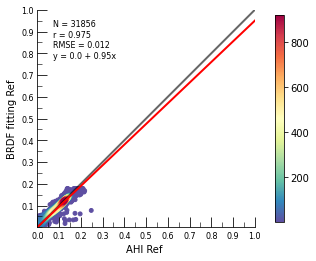

In [614]:
# r = 5
# a,b = 49*5,49*6

# X = np.array(Ref)[a:b,i_idx-r:i_idx+r,j_idx-r:j_idx+r]
# Y = fiso + np.array(kvol)[a:b,i_idx-r:i_idx+r,j_idx-r:j_idx+r]*fvol + np.array(kgeo)[a:b,i_idx-r:i_idx+r,j_idx-r:j_idx+r]*fgeo
i,j = 0,8
X = X_Fitting.reshape(-1)
Y = Y_MaxMin.reshape(-1)

nan_mask = ~np.isnan(X.reshape(-1))
X = X.reshape(-1)[nan_mask]
Y = Y.reshape(-1)[nan_mask]

nan_mask = ~np.isnan(Y.reshape(-1))
X = X.reshape(-1)[nan_mask]
Y = Y.reshape(-1)[nan_mask]

pccs = np.corrcoef(X, Y)[0,1]
r = round(pccs.astype('float64'),3)

rmse = np.sqrt(mean_squared_error(X ,Y))
p = np.polyfit(X ,Y,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

axis_min = 0
axis_max = 1

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

# Calculate the point density
xy = np.vstack([X,Y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
X, Y, z = X[idx], Y[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter(X,Y,marker='o', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(X,Y,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("AHI Ref ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=0.6)
ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.text(text_x,text_y,s = 'N = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(X),r,rmse,b,k),fontsize=8)

cax = add_right_cax(ax1, pad=0.06, width=0.03)
cb = fig.colorbar(im,cax=cax)
cb.ax.set_xlabel('Count',rotation=360)
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

# Pandas

In [ ]:
import pandas as pd

In [ ]:
FISO = fiso.reshape(-1)[~np.isnan(fiso.reshape(-1))]

In [ ]:
df = pd.DataFrame(FISO)
df.describe()

,0
count,100.000000
mean,0.514242
std,0.053382
min,0.412535
25%,0.477413
50%,0.510679
75%,0.545420
max,0.659810


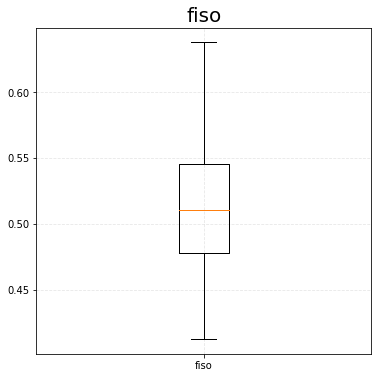

In [ ]:
FISO = fiso.reshape(-1)[~np.isnan(fiso.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FISO,showfliers = False,labels=['fiso'])
plt.title('fiso',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

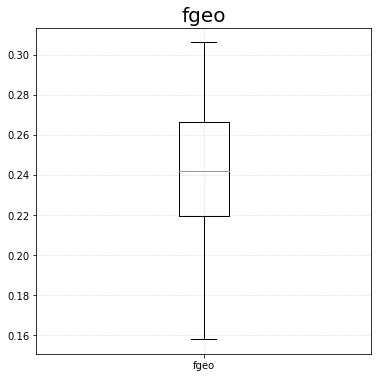

In [ ]:
FGEO = fgeo.reshape(-1)[~np.isnan(fgeo.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FGEO,showfliers = False,labels=['fgeo'])
plt.title('fgeo',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

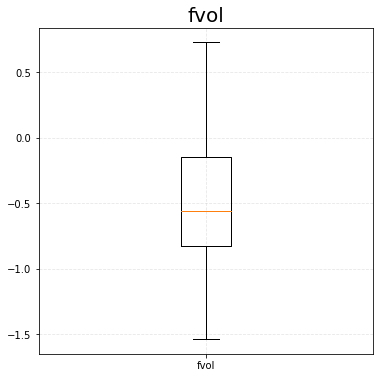

In [ ]:
FVOL = fvol.reshape(-1)[~np.isnan(fvol.reshape(-1))]
fig = plt.figure(figsize=(6,6))
plt.boxplot(FVOL,showfliers = False,labels=['fvol'])
plt.title('fvol',fontsize = 20)
plt.grid(linestyle="--", alpha=0.3)
# plt.ylabel('atm – cm',fontsize = 12)
# plt.savefig('AOT550.jpg',dpi = 1000)
plt.show()

In [ ]:
with open(LAND_MASK_PATH,'rb') as fp:
    Ocean_mask = np.frombuffer(fp.read(),dtype='u1').reshape(12000,12000)[1000:4000,3500:6500]

# Read SGLI

In [17]:
# i_idx,j_idx = 8500,3500
# i_idx,j_idx = 1500,3000
# i_idx,j_idx = 1700,3900

# i_idx,j_idx = 8152,5715

# 李爽
i_idx,j_idx = 9142,3220
# i_idx,j_idx = 7548,5825
# i_idx,j_idx = 8698,4470

# i_idx,j_idx = 8900,5740
# i_idx,j_idx = 9000,4000

In [600]:
i_idx,j_idx = 8400,4000

In [576]:
tile

'1129'

In [ ]:
r = 50
AHI_lat = np.linspace(60,-59.99,12000)[i_idx-r:i_idx+r]
AHI_lon = np.linspace(85,204.99,12000)[j_idx-r:j_idx+r]
SGLI_VZA = []
SGLI_SZA = []
SGLI_RAA = []
SGLI_VAA = []
SGLI_SAA = []
SGLI_Ref = []
SGLI_band = 'Rs_VN10'
# SGLI_band = 'Rs_SW03'

for d in range(21,26):
    date_start = '2018-01-{} 00:00'.format(str(d))
    date_end = '2018-01-{} 06:00'.format(str(d))
    date_t = dt.timedelta(days=1)
    # date_t = dt.timedelta(minutes=30)
    date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
    date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
    date_time_now = date_s
    b = 4
    
    c_SGLI_VZA = []
    c_SGLI_SZA = []
    c_SGLI_RAA = []
    c_SGLI_VAA = []
    c_SGLI_SAA = []
    c_SGLI_Ref = []
    # time_list = []
    while date_time_now <= date_e:
        print(date_time_now)
        start_time = T.time()
        YYYY,MM,DD,HH,MIN,date= Time_split_SGLI(date_time_now)
        for lat_idx in range(2*r):
            for lon_idx in range(2*r):

                # 获取该经纬度的Tile号
                # print(lat_idx,lon_idx) 

                tile = lonlat2tileidx([AHI_lat[lat_idx],AHI_lon[lon_idx]])

                # print(tile) 
#                 # SGLI 文件名
                SGLI_tile_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001.h5'.format(date,tile)
                SGLI_VZA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_zenith.tif'.format(date,tile)
                SGLI_VAA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_azimuth.tif'.format(date,tile)
                SGLI_TIME_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Obs_time.tif'.format(date,tile)
                SGLI_REF_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_{}.tif'.format(date,tile,SGLI_band)

                # 存在SGLI文件
                # print('1')
                if os.path.exists(reporjection_file_path + SGLI_VAA_filename) and os.path.exists(reporjection_file_path + SGLI_VZA_filename) and os.path.exists(reporjection_file_path + SGLI_TIME_filename):
                    # print('1')
                    # 读取该像素经纬度SGLI的VZA和VAA
                    SGLI_VZA_PL = SGLI_2_AHI_GEO(reporjection_file_path + SGLI_VZA_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                    SGLI_VAA_PL = SGLI_2_AHI_GEO(reporjection_file_path + SGLI_VAA_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])

                    if not np.isnan(SGLI_VZA_PL) and not np.isnan(SGLI_VAA_PL):
                        if SGLI_VAA_PL < 0:
                            SGLI_VAA_PL = SGLI_VAA_PL + 360
                    # 计算该像素经纬度SGLI的SZA和SAA

                        SGLI_Obs_TIME = SGLI_2_AHI_TIME(reporjection_file_path + SGLI_TIME_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                        # print(SGLI_Obs_TIME.values[0])
                        # print(SGLI_Obs_TIME)
                        if not np.isnan(SGLI_Obs_TIME):
                            # print(SGLI_Obs_TIME)
                            SGLI_MIN = int(round(math.modf(SGLI_Obs_TIME)[0],3)*60)
                            SGLI_HH = int(math.modf(SGLI_Obs_TIME)[1])
                            if SGLI_HH <= 23 and SGLI_MIN >= 0 and SGLI_MIN <= 59:
                                SGLI_SAA_PL,SGLI_SZA_PL = SGLI_SA(SGLI_HH,SGLI_MIN,AHI_lat[lat_idx],AHI_lon[lon_idx])
                                SGLI_Ref_PL = SGLI_2_AHI_Ref(reporjection_file_path + SGLI_REF_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                                # 读取AHI的SZA、SAA
                                SGLI_RAA_PL = abs(SGLI_SAA_PL - SGLI_VAA_PL.data[0])
                                SGLI_RAA_PL = np.where(SGLI_RAA_PL>180,360-SGLI_RAA_PL,SGLI_RAA_PL)
                                c_SGLI_VZA.append(SGLI_VZA_PL.values[0])
                                c_SGLI_SZA.append(SGLI_SZA_PL)
                                c_SGLI_RAA.append(SGLI_RAA_PL)
                                c_SGLI_SAA.append(SGLI_SAA_PL)
                                c_SGLI_VAA.append(SGLI_VAA_PL)
                                if np.isnan(SGLI_Ref_PL):
                                    c_SGLI_Ref.append(SGLI_Ref_PL)
                                else:
                                    c_SGLI_Ref.append(SGLI_Ref_PL.values[0])
                                    
                            else:
                                c_SGLI_VZA.append(np.nan)
                                c_SGLI_SZA.append(np.nan)
                                c_SGLI_RAA.append(np.nan)
                                c_SGLI_SAA.append(np.nan)
                                c_SGLI_VAA.append(np.nan)
                                c_SGLI_Ref.append(np.nan)
                        else:
                            c_SGLI_VZA.append(np.nan)
                            c_SGLI_SZA.append(np.nan)
                            c_SGLI_RAA.append(np.nan)
                            c_SGLI_SAA.append(np.nan)
                            c_SGLI_VAA.append(np.nan)
                            c_SGLI_Ref.append(np.nan)
                    else:
                        c_SGLI_VZA.append(np.nan)
                        c_SGLI_SZA.append(np.nan)
                        c_SGLI_RAA.append(np.nan)
                        c_SGLI_SAA.append(np.nan)
                        c_SGLI_VAA.append(np.nan)
                        c_SGLI_Ref.append(np.nan)
                else:
                    c_SGLI_VZA.append(np.nan)
                    c_SGLI_SZA.append(np.nan)
                    c_SGLI_RAA.append(np.nan)
                    c_SGLI_SAA.append(np.nan)
                    c_SGLI_VAA.append(np.nan)
                    c_SGLI_Ref.append(np.nan)

        SGLI_VZA.append(np.array(c_SGLI_VZA))
        SGLI_SZA.append(np.array(c_SGLI_SZA))
        SGLI_RAA.append(np.array(c_SGLI_RAA))
        SGLI_SAA.append(np.array(c_SGLI_SAA))
        SGLI_VAA.append(np.array(c_SGLI_VAA))
        SGLI_Ref.append(np.array(c_SGLI_Ref))
        date_time_now = date_time_now + date_t                            

2018-01-21 00:00:00
2018-01-22 00:00:00


In [61]:
SGLI_Ref

[array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([0.2555, 0.1973, 0.2034, ..., 0.2298, 0.2072, 0.2197]),
 array([0.3151, 0.288 , 0.2877, ..., 0.3078, 0.3096, 0.3458]),
 array([nan, nan, nan, ..., nan, nan, nan])]

In [39]:
np.nanmax(SGLI_Ref[3].reshape(100,100))

<ipython-input-39-2ac96bf0c53d>:1: RuntimeWarning: All-NaN slice encountered
  np.nanmax(SGLI_Ref[3].reshape(100,100))


nan

In [62]:
XX = []
YY = []
r = 50

dlist = [2]
for i in dlist:
    if SGLI_SZA[i].size != 0:
        SGLI_kvol = RTK(SGLI_SZA[i],SGLI_VZA[i],SGLI_RAA[i]).reshape(2*r,2*r)
        SGLI_kgeo = LSR_MaxMin(SGLI_SZA[i],SGLI_VZA[i],SGLI_RAA[i]).reshape(2*r,2*r)
        XX.append(SGLI_Ref[i].reshape(-1))
        YY.append(fiso_fitting + np.array(SGLI_kvol)*fvol_fitting + np.array(SGLI_kgeo)*fgeo_fitting)

In [66]:
fiso_fitting

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [59]:
# XX = np.array(XX).reshape(-1) * 0.972 + 0.001

# XX = np.array(XX).reshape(-1) * 0.983
# XX = np.array(XX).reshape(-1) * 0.981 + 0.001 # Open S
YY = np.array(YY).reshape(-1)
# XX = np.array(XX).reshape(-1)
XX = np.array(XX).reshape(-1) * 0.984 # Grassland Band4
# d_idx = 1
# XX = SGLI_Ref[i].reshape(-1) * 0.981 + 0.001 # Open S
# XX = SGLI_Ref[i].reshape(-1) * 0.98 + 0.002 # Barren
# XX = SGLI_Ref[d_idx].reshape(-1) + 0.1603 # Croplands
# YY = Y_SGLI.reshape(-1)

nan_mask = ~np.isnan(YY.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]


nan_mask = ~np.isnan(XX.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]

rmse = np.sqrt(mean_squared_error(XX ,YY))
p = np.polyfit(XX ,YY,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

pccs = np.corrcoef(XX, YY)[0,1]
r = round(pccs.astype('float64'),3)

axis_min = 0
axis_max = 0.5
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

# Calculate the point density
xy = np.vstack([XX,YY])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
XX, YY, z = XX[idx], YY[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter(XX,YY,marker='o', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(XX,YY,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("SGLI VN10 ",fontsize=10)
ax1.set_ylabel("AHI BRDF fitting Band4",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=1)
# ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.text(text_x,text_y,s = 'N = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(XX),r,rmse,b,k),fontsize=8)
ax1.text(0.3,0.1,s = 'Open Shurbland\nAustralia\n2018/01/25',fontsize=10)

# cax = add_right_cax(ax1, pad=0.06, width=0.03)
# cb = fig.colorbar(im,cax=cax)
# cb.ax.set_xlabel('Count',rotation=360)
# plt.title('2018/07/26')
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

# MISR

In [ ]:
MISR_Ref = np.array([[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, 0.42162606, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1], [-0.1, -0.1, 0.44482085, 0.40644264, 0.40644264, 0.3562382, 0.35143137, -0.1, -0.1, -0.1], [-0.1, -0.1, 0.47709516, 0.38515535, 0.3885125, 0.3885125, 0.35967162, -0.1, -0.1, -0.1], [-0.1, 0.43329975, 0.43329975, 0.44978026, 0.3927852, 0.3927852, 0.4154459, -0.1, -0.1, -0.1], [0.5289782, -0.1, -0.1, 0.3878258, 0.34860831, 0.37500763, 0.37500763, -0.1, -0.1, -0.1]])
MISR_Ref = np.where(MISR_Ref==-0.1,np.nan,MISR_Ref)

In [ ]:
MISR_VAA = np.full((10,10),109.05)
MISR_VZA = np.full((10,10),1.41)

In [ ]:
def MISR_SA(y,m,d,h,_min,lat,lon):

    dt = datetime.datetime(y,m,d,h,_min)
    
    SAA,SZA = calc_sunpos(dt,lat,lon)
    return SAA,SZA
MISR_SAA,MISR_SZA = [],[]
for lat_idx in range(10):
    for lon_idx in range(10):
        a = MISR_SA(2018,7,30,1,26,AHI_lat[lat_idx],AHI_lon[lon_idx])
        MISR_SAA.append(a[0])
        MISR_SZA.append(a[1])
MISR_SAA = np.array(MISR_SAA).reshape(10,10)
MISR_SZA = np.array(MISR_SZA).reshape(10,10)


In [ ]:
MISR_RAA = MISR_SAA - MISR_VAA

In [ ]:
MISR_RAA

array([[36.12464628, 36.14258236, 36.16053209, 36.17846817, 36.19641791,
        36.21436765, 36.23233104, 36.25029444, 36.26825784, 36.2862349 ],
       [36.11407315, 36.13200922, 36.1499453 , 36.16789504, 36.18584478,
        36.20380817, 36.22175791, 36.23973497, 36.25769837, 36.27567542],
       [36.10347269, 36.12142243, 36.13935851, 36.15730824, 36.17527164,
        36.19322138, 36.21118478, 36.22916183, 36.24712523, 36.26510229],
       [36.0928859 , 36.11082198, 36.12877171, 36.14672145, 36.16468485,
        36.18264825, 36.20061164, 36.21857504, 36.2365521 , 36.25452916],
       [36.08227179, 36.10022152, 36.11817126, 36.13613466, 36.1540844 ,
        36.17206145, 36.19002485, 36.20800191, 36.22597897, 36.24395602],
       [36.07167133, 36.08962107, 36.10757081, 36.1255342 , 36.1434976 ,
        36.161461  , 36.17943806, 36.19740146, 36.21539217, 36.23336923],
       [36.06104356, 36.07900696, 36.09695669, 36.11492009, 36.13288349,
        36.15086055, 36.1688376 , 36.18681466

In [ ]:
MISR_kvol = RTK(MISR_SZA,MISR_VZA,MISR_RAA).reshape(10,10)
MISR_kgeo = LSR(MISR_SZA,MISR_VZA,MISR_RAA).reshape(10,10)
Y_MISR = fiso + np.array(MISR_kvol)[:,:]*fvol + np.array(MISR_kgeo)[:,:]*fgeo

(0.3, 0.8)

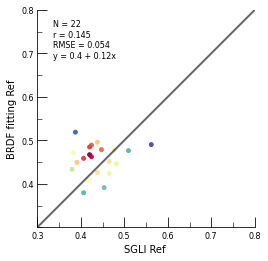

In [ ]:

# XX = np.array(XX).reshape(-1) + 0.1603
# YY = np.array(YY).reshape(-1)

# XX = SGLI_Ref[d_idx].reshape(-1) * 0.989 + 0.1021 # EBF
XX = MISR_Ref.reshape(-1)*1.01 + 0.02776 # Croplands
YY = Y_MISR.reshape(-1)

nan_mask = ~np.isnan(YY.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]


nan_mask = ~np.isnan(XX.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]

rmse = np.sqrt(mean_squared_error(XX ,YY))
p = np.polyfit(XX ,YY,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

pccs = np.corrcoef(XX, YY)[0,1]
r = round(pccs.astype('float64'),3)

axis_min = 0.3
axis_max = 0.8
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

# Calculate the point density
xy = np.vstack([XX,YY])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
XX, YY, z = XX[idx], YY[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter(XX,YY,marker='o', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(XX,YY,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("SGLI Ref ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=0.6)
# ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.text(text_x,text_y,s = 'N = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(XX),r,rmse,b,k),fontsize=8)
# cax = add_right_cax(ax1, pad=0.06, width=0.03)
# cb = fig.colorbar(im,cax=cax)
# cb.ax.set_xlabel('Count',rotation=360)
# plt.title('2018/07/26')
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

In [ ]:
import pandas as pd
data = pd.DataFrame({'SGLI':XX, 
                     'AHI':YY})

In [ ]:
data.corr()

,SGLI,AHI
SGLI,1.000000,0.116162
AHI,0.116162,1.000000


In [ ]:
data.corr('kendall')

,SGLI,AHI
SGLI,1.000000,0.048495
AHI,0.048495,1.000000


In [ ]:
data.corr('spearman')

,SGLI,AHI
SGLI,1.00000,0.07325
AHI,0.07325,1.00000


# MCD43

In [14]:
from suncalc import get_position, get_times

In [15]:
class AHI_angle:
    def __init__(self,date):
        self.date = date        
    def read_angle_data(self):
        
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2018{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2018{}5.dat'.format(AHI_date)
        
        AHI_SZA_File = open(SZA_PATH + sza_file_name,'rb')
        AHI_SZA = np.frombuffer(AHI_SZA_File.read(),dtype='u2').reshape(3000,3000) / 100
        AHI_SZA_File.close()
        AHI_SZA=cv2.resize(np.array(AHI_SZA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)
        
        
        AHI_SAA_File = open(SAA_PATH + saa_file_name,'rb')
        AHI_SAA = np.frombuffer(AHI_SAA_File.read(),dtype='u2').reshape(3000,3000) / 100
        AHI_SAA_File.close()
        AHI_SAA=cv2.resize(np.array(AHI_SAA,dtype='float64'),(12000,12000),interpolation=cv2.INTER_NEAREST)
        
        return AHI_SZA,AHI_SAA

SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'

In [16]:
with open('/data01/people/liwei/Data/MCD43A4_AHI/MCD43A4_20180101_Band2.dat','rb') as fp:
    MCD43 = np.frombuffer(fp.read(),dtype='int16').reshape(12000,12000) * 0.0001
r = 50
MCD43 = np.where(MCD43==3.2767,np.nan,MCD43)
MCD43_Ref = MCD43[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

In [17]:

MCD43_lat = np.linspace(60,-59.99,12000)[i_idx-r:i_idx+r]
MCD43_lon = np.linspace(85,204.99,12000)[j_idx-r:j_idx+r]

In [18]:
date = dt.datetime.strptime('2018-01-01',"%Y-%m-%d")

In [19]:
solar_noon = get_times(date, MCD43_lon[6], MCD43_lat[6])['solar_noon']

In [20]:
AHI_2_MODIS_SZA,AHI_2_MODIS_SAA = AHI_angle(Time_split(solar_noon)[5]).read_angle_data()

In [21]:
AHI_2_MODIS_SZA = AHI_2_MODIS_SZA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]
AHI_2_MODIS_SAA = AHI_2_MODIS_SAA[i_idx-r:i_idx+r,j_idx-r:j_idx+r]

In [25]:
MODIS_VZA = np.zeros((2*r,2*r))

In [26]:
MODIS_kvol = RTK(AHI_2_MODIS_SZA,MODIS_VZA,360 - AHI_2_MODIS_SAA).reshape(2*r,2*r)
MODIS_kgeo = LSR(AHI_2_MODIS_SZA,MODIS_VZA,360 - AHI_2_MODIS_SAA).reshape(2*r,2*r)

In [27]:
AHI_2_MODIS_Ref = fiso_fitting + np.array(MODIS_kvol)*fvol_fitting + np.array(MODIS_kgeo)*fgeo_fitting

In [28]:
AHI_2_MODIS_Ref

array([[0.36690487, 0.33697842, 0.31097783, ..., 0.26837974, 0.26926791,
        0.25915099],
       [0.3313562 , 0.31964984, 0.31317757, ..., 0.27005011, 0.26580618,
        0.26203234],
       [0.30779812, 0.30517211, 0.31268931, ..., 0.25924495, 0.25246981,
        0.25156101],
       ...,
       [0.26513535, 0.27217104, 0.27228121, ..., 0.29412287, 0.30485138,
        0.3063822 ],
       [0.2656551 , 0.26093145, 0.26305026, ..., 0.32753623, 0.32284412,
        0.31464441],
       [0.26221986, 0.25875656, 0.25981306, ..., 0.34246842, 0.31886138,
        0.28964328]])

In [29]:
MCD43_Ref

array([[0.3155, 0.2994, 0.2935, ..., 0.3044, 0.3162, 0.314 ],
       [0.302 , 0.2882, 0.3009, ..., 0.3101, 0.3209, 0.3237],
       [0.2809, 0.286 , 0.2805, ..., 0.3424, 0.3417, 0.3361],
       ...,
       [0.2949, 0.3038, 0.2849, ..., 0.3169, 0.3256, 0.3257],
       [0.31  , 0.2971, 0.2997, ..., 0.3348, 0.2941, 0.3159],
       [0.3082, 0.2918, 0.2995, ..., 0.3277, 0.301 , 0.3133]])

(0.0, 0.5)

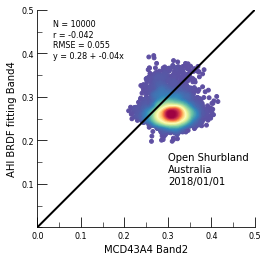

In [30]:
# XX = np.array(XX).reshape(-1) * 0.972 + 0.001

# XX = np.array(XX).reshape(-1) * 0.983
# XX = np.array(XX).reshape(-1) * 0.981 + 0.001 # Open S
YY = np.array(AHI_2_MODIS_Ref).reshape(-1)
XX = np.array(MCD43_Ref).reshape(-1) * 1.008
# d_idx = 1
# XX = SGLI_Ref[i].reshape(-1) * 0.981 + 0.001 # Open S
# XX = SGLI_Ref[i].reshape(-1) * 0.98 + 0.002 # Barren
# XX = SGLI_Ref[d_idx].reshape(-1) + 0.1603 # Croplands
# YY = Y_SGLI.reshape(-1)

nan_mask = ~np.isnan(YY.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]


nan_mask = ~np.isnan(XX.reshape(-1))
XX = XX.reshape(-1)[nan_mask]
YY = YY.reshape(-1)[nan_mask]

rmse = np.sqrt(mean_squared_error(XX ,YY))
p = np.polyfit(XX ,YY,1)    

k = round(p[0],2)
b = round(p[1],2)
rmse = round(rmse.astype('float64'),3)

pccs = np.corrcoef(XX, YY)[0,1]
r = round(pccs.astype('float64'),3)

axis_min = 0
axis_max = 0.5
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111,aspect='equal')

x = np.arange(axis_min,axis_max+1)
y = 1 * x

xx = np.arange(0,1+0.1,0.05) 
yy = k * xx + b

# Calculate the point density
xy = np.vstack([XX,YY])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
XX, YY, z = XX[idx], YY[idx], z[idx]

ax1.minorticks_on()
# x_major_locator = plt.MultipleLocator(5)
x_minor_locator = plt.MultipleLocator(0.05)
ax1.xaxis.set_minor_locator(x_minor_locator)
# ax.xaxis.set_major_locator(x_major_locator)
ax1.yaxis.set_minor_locator(x_minor_locator)
# ax.yaxis.set_major_locator(x_major_locator)

ax1.tick_params(axis="y",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)

ax1.tick_params(axis="x",which='minor',length=5,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')


im = ax1.scatter(XX,YY,marker='o', c=z,s=15,cmap='Spectral_r')
# im = ax1.scatter(XX,YY,marker='o', c='k',s=15)

ax1.set_xticks(np.arange(axis_min,axis_max+0.1,0.1))
ax1.set_yticks(np.arange(axis_min+0.1,axis_max+0.1,0.1))

ax1.set_xlabel("MCD43A4 Band2",fontsize=10)
ax1.set_ylabel("AHI BRDF fitting Band4",fontsize=10)


ax1.plot(x,y,color='k',linewidth=2,linestyle='-',alpha=1)
# ax1.plot(xx,yy,color='r',linewidth=2,linestyle='-') 


text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.text(text_x,text_y,s = 'N = {}\nr = {}\nRMSE = {}\ny = {} + {}x'.format(len(XX),r,rmse,b,k),fontsize=8)
ax1.text(0.3,0.1,s = 'Open Shurbland\nAustralia\n2018/01/01',fontsize=10)

# cax = add_right_cax(ax1, pad=0.06, width=0.03)
# cb = fig.colorbar(im,cax=cax)
# cb.ax.set_xlabel('Count',rotation=360)
# plt.title('2018/07/26')
ax1.set_xlim(axis_min,axis_max)
ax1.set_ylim(axis_min,axis_max)

array([[0.36115193, 0.35041306, 0.34532845, 0.35158777, 0.35979793,
        0.35319989, 0.35529848, 0.33573133, 0.33233089, 0.33292556],
       [0.37466703, 0.33156291, 0.32613826, 0.35369628, 0.36181587,
        0.36949787, 0.38256327, 0.36789317, 0.33763051, 0.33286956],
       [0.34487277, 0.32198772, 0.32703306, 0.34546857, 0.35055469,
        0.35925469, 0.37272251, 0.37517751, 0.34466997, 0.34628923],
       [0.34592732, 0.34604913, 0.35448655, 0.34619727, 0.33389259,
        0.34728277, 0.35282728, 0.35725958, 0.35134127, 0.3375593 ],
       [0.32974428, 0.36841576, 0.38287166, 0.37824598, 0.35682226,
        0.33068596, 0.33335449, 0.35215249, 0.33905416, 0.32231621],
       [0.30863843, 0.33065916, 0.36534601, 0.38345861, 0.36525724,
        0.32652581, 0.31329218, 0.32313252, 0.32144885, 0.30864765],
       [0.30679713, 0.30986046, 0.33333567, 0.37758682, 0.3470644 ,
        0.32703405, 0.3251426 , 0.32813977, 0.30787244, 0.31018558],
       [0.29346659, 0.30001181, 0.3221542

# Polar

In [ ]:
SGLI_SAA_pixel = []
SGLI_SZA_pixel = []
SGLI_VAA_pixel = []
SGLI_VZA_pixel = []

for i in range(7):
    if SGLI_SAA[i].size != 0:
        SGLI_SAA_pixel.append(SGLI_SAA[i].reshape(10,10)[5,5])
        SGLI_SZA_pixel.append(SGLI_SZA[i].reshape(10,10)[5,5])
        SGLI_VAA_pixel.append(SGLI_VAA[i].reshape(10,10)[5,5])
        SGLI_VZA_pixel.append(SGLI_VZA[i].reshape(10,10)[5,5])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

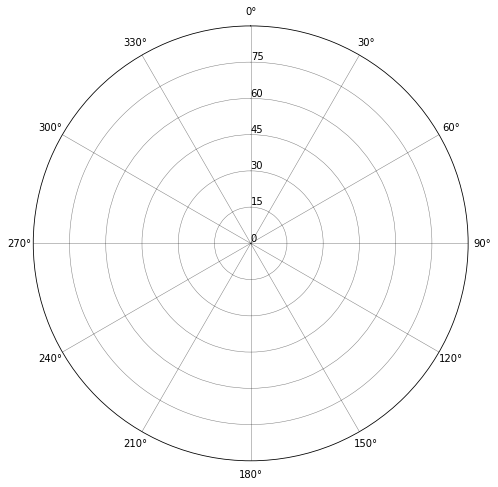

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(0, 90, 15))
ax.set_rlabel_position(0.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
ax.set_axisbelow('True')
# plt.scatter(np.radians(np.array(SAA_valid)[:,i_idx,j_idx]),np.array(SZA_valid)[:,i_idx,j_idx], c='none', marker='o', edgecolors='r', s=40)
plt.scatter(np.radians(np.array(AHI_SAA)[:,i_idx,j_idx]),np.array(AHI_SZA)[:,i_idx,j_idx], c='g', marker='o', s=40)
plt.scatter(np.radians(VAA[1400:1900,5450:6150][i_idx,j_idx]),VZA[i_idx,j_idx], c='blue', marker='o', s=40)

plt.scatter(np.radians(np.array(SGLI_SAA_pixel)),np.array(SGLI_SZA_pixel), c='none', marker='o', edgecolors='k', s=40)
plt.scatter(np.radians(np.array(SGLI_VAA_pixel)),np.array(SGLI_VZA_pixel), c='none', marker='o', edgecolors='r', s=40)

            
plt.show()

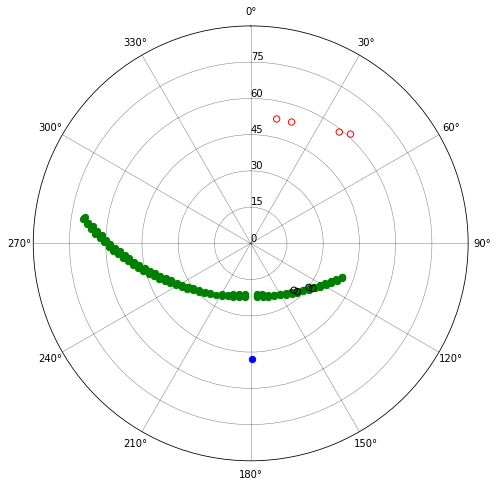

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='polar')
ax.set_theta_offset(np.pi/2)
#设置极坐标系的起始角度为90°
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
ax.set_thetamin(0.0)  
ax.set_thetamax(360.0)
ax.set_rgrids(np.arange(0, 90, 15))
ax.set_rlabel_position(0.0)
ax.set_rlim(0.0, 90.0)
# ax.set_yticklabels(['0', '1000', '2000', '3000', '4000', '5000'])
ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)
ax.set_axisbelow('True')
# plt.scatter(np.radians(np.array(SAA_valid)[:,i_idx,j_idx]),np.array(SZA_valid)[:,i_idx,j_idx], c='none', marker='o', edgecolors='r', s=40)
plt.scatter(np.radians(np.array(AHI_SAA)[:,i_idx,j_idx]),np.array(AHI_SZA)[:,i_idx,j_idx], c='g', marker='o', s=40)
plt.scatter(np.radians(VAA[1400:1900,5450:6150][i_idx,j_idx]),VZA[i_idx,j_idx], c='blue', marker='o', s=40)

plt.scatter(np.radians(np.array(SGLI_SAA_pixel)),np.array(SGLI_SZA_pixel), c='none', marker='o', edgecolors='k', s=40)
plt.scatter(np.radians(np.array(SGLI_VAA_pixel)),np.array(SGLI_VZA_pixel), c='none', marker='o', edgecolors='r', s=40)

            
plt.show()

# ALBEDO

In [ ]:
def R(vza,raa):
    cos_xi = np.cos(np.radians(sza)) * np.cos(np.radians(vza)) + np.sin(np.radians(sza)) * np.sin(np.radians(vza))* np.cos(np.radians(raa))
    xi = np.arccos(cos_xi)
    rtk = (((np.pi/2 - xi) * cos_xi + np.sin(xi)) / (np.cos(np.radians(sza)) + np.cos(np.radians(vza)))) - np.pi/4


    
    cos_sza = np.cos(np.radians(sza))
    cos_vza = np.cos(np.radians(vza))
    cos_raa = np.cos(np.radians(raa))

    sin_sza = np.sin(np.radians(sza))
    sin_vza = np.sin(np.radians(vza))
    sin_raa = np.sin(np.radians(raa))

    tan_sza = np.tan(np.radians(sza))
    tan_vza = np.tan(np.radians(vza))

    sec_sza = 1 / cos_sza
    sec_vza = 1 / cos_vza

    _sza = np.arctan(tan_sza)
    _vza = np.arctan(tan_vza)

    cos__sza = np.cos(_sza)
    cos__vza = np.cos(_vza)
    sin__sza = np.sin(_sza)
    sin__vza = np.sin(_vza)
    sec__sza = 1 / cos__sza
    sec__vza = 1 / cos__vza

    cos__xi = cos__sza * cos__vza + sin__sza * sin__vza * cos_raa
    D = np.sqrt(np.square(tan_sza) + np.square(tan_vza) - 2 * tan_sza * tan_vza * cos_raa)
    cos_t = (2 * (np.sqrt(np.square(D) + np.square(tan_sza * tan_vza * sin_raa)))) / (sec__sza + sec__vza)
    
    t = np.arccos(cos_t)
    O = (1/np.pi) * (t - np.sin(t) * cos_t) *  (sec__sza + sec__vza)
    lsr = O - sec__sza - sec__vza + 0.5 * (1 + cos__xi) * sec__sza * sec__vza
    
    
    
    return (fi + fg*lsr + fv*rtk) * cos_vza * sin_vza / np.pi


In [ ]:
fi = fiso[5,5]
fg = fgeo[5,5]
fv = fvol[5,5]

In [ ]:
from scipy import integrate
v, err = integrate.dblquad(R,0, np.pi/2,0,2*np.pi)

<ipython-input-1446-6e951a8ab1ab>:36: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


In [ ]:
v

nan

In [ ]:
BSA = []
for sza in range(0,80):
    print(sza)
    v, err = integrate.dblquad(R,0, np.pi/2,0,2*np.pi)
    BSA.append(v)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


<ipython-input-1440-9e97b4602cfe>:36: RuntimeWarning: invalid value encountered in arccos
  t = np.arccos(cos_t)


55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


(0.0, 0.6)

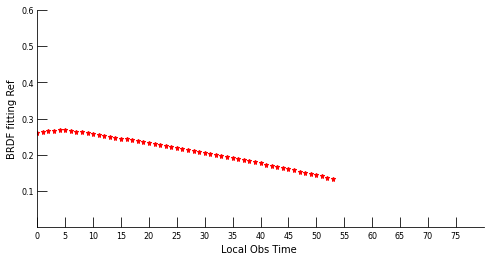

In [ ]:
axis_min = 0
axis_max = 0.6

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)


ax1.tick_params(axis="y",which='major',length=10,direction='in',labelsize=8)
ax1.tick_params(axis="x",which='major',length=10,direction='in',labelsize=8)


ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

ax1.plot(np.arange(0,80,1),np.array(BSA),color = 'r',marker="*",markersize=5,linewidth=0,label='{},{}'.format(i,j))

ax1.set_xticks(np.arange(0,80,5))
ax1.set_yticks(np.arange(axis_min+0.1,1.1,0.1))

ax1.set_xlabel("Local Obs Time ",fontsize=10)
ax1.set_ylabel("BRDF fitting Ref",fontsize=10)



text_x = axis_min + (axis_max - axis_min) * 0.07
text_y = axis_max - (axis_max - axis_min) * 0.22

ax1.set_xlim(axis_min,80)
ax1.set_ylim(axis_min,axis_max)
# plt.legend()